# Predicting prices with a single-asset regression model

## Preparing the independent and target variables

In [8]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(
    symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(
    symbol='GS', outputsize='full')

In [9]:
import pandas as pd
import numpy as np

df_x = pd.DataFrame({'GS': df_gs['5. adjusted close']})[::-1]

In [10]:
df_x.head()

,GS
date,
1999-11-01,54.645701
1999-11-02,54.937124
1999-11-03,54.149495
1999-11-04,55.236423
1999-11-05,58.040382


In [11]:
jpm_prices = df_jpm['5. adjusted close'][::-1]

In [12]:
jpm_prices.head()

date
1999-11-01    29.068758
1999-11-02    29.113982
1999-11-03    28.679134
1999-11-04    29.263570
1999-11-05    30.004552
Name: 5. adjusted close, dtype: float64

## Writing the linear regression model

In [13]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [14]:
start_date, end_date = '2019-01-01', '2019-12-31'
df.loc[start_date:].index

NameError: name 'df' is not defined

In [15]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2019', 
                       end_date='2020', lookback_period=20)

In [16]:
res = linear_reg_model.df_result.copy()
res.head()

,Actual,Predicted
2019-01-02,92.905977,93.294692
2019-01-03,91.596256,91.876090
2019-01-04,94.972990,94.799689
2019-01-07,95.039015,95.306311
2019-01-08,94.859803,95.010720


In [17]:
res['Actual'].diff()

2019-01-02         NaN
2019-01-03   -1.309721
2019-01-04    3.376734
2019-01-07    0.066026
2019-01-08   -0.179212
                ...   
2020-11-19    0.310000
2020-11-20   -0.990000
2020-11-23    3.300000
2020-11-24    5.450000
2020-11-25   -1.290000
Name: Actual, Length: 481, dtype: float64

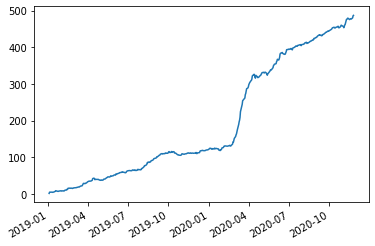

In [18]:
(np.sign(res['Predicted'].shift(-1) - res['Actual']).shift() * res['Actual'].diff()).cumsum().plot()

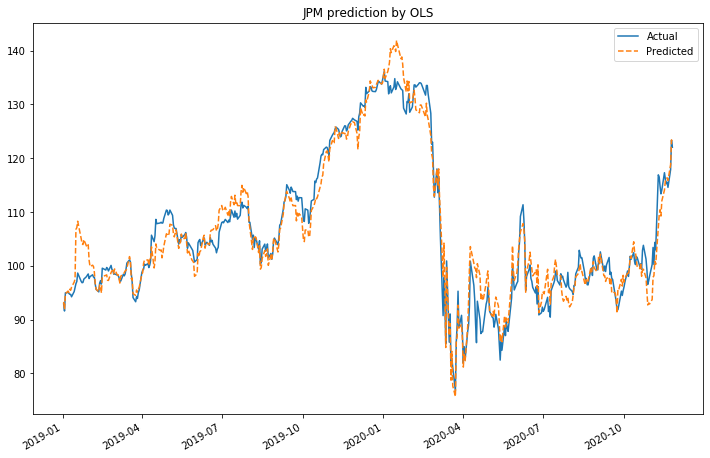

In [19]:
%matplotlib inline

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

## Risk metrics for measuring prediction performance

### Mean absolute error (MAE) as a risk metric

In [20]:
from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

mean absolute error: 2.26817180607382


#### Mean squared error (MSE) as a risk metric

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

mean squared error: 9.234106094305554


### Explained variance score as a risk metric

In [22]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: 0.9473357426713757


### R<sup>2</sup> as a risk metric

In [23]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)

r2 score: 0.947253827162933


## Ridge regression

In [24]:
from sklearn.linear_model import Ridge

class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

In [25]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

In [26]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

In [27]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 1.3848472478426046
mean_squared_error: 3.5887619021876467
explained_variance_score: 0.9561803757959388
r2_score: 0.9527982083910924


# Predicting returns with a cross-asset momentum model

## Preparing the independent variables

In [31]:
df_spx, meta_data = ts.get_daily_adjusted(
    symbol='SPY', outputsize='full')
df_gld, meta_data = ts.get_daily_adjusted(
    symbol='GLD', outputsize='full')
df_dxy, dxy_meta_data = ts.get_daily_adjusted(
    symbol='UUP', outputsize='full')
df_ief, meta_data = ts.get_daily_adjusted(
    symbol='IEF', outputsize='full')

In [32]:
import pandas as pd

df_assets = pd.DataFrame({
    'SPX': df_spx['5. adjusted close'],
    'GLD': df_gld['5. adjusted close'],
    'UUP': df_dxy['5. adjusted close'],
    'IEF': df_ief['5. adjusted close'],
}).dropna()

In [33]:
df_assets_1m = df_assets.pct_change(periods=20)
df_assets_1m.columns = ['%s_1m'%col for col in df_assets.columns]

df_assets_3m = df_assets.pct_change(periods=60)
df_assets_3m.columns = ['%s_3m'%col for col in df_assets.columns]

df_assets_6m = df_assets.pct_change(periods=120)
df_assets_6m.columns = ['%s_6m'%col for col in df_assets.columns]

df_assets_12m = df_assets.pct_change(periods=240)
df_assets_12m.columns = ['%s_12m'%col for col in df_assets.columns]

In [34]:
df_lagged = df_assets_1m.join(df_assets_3m)\
    .join(df_assets_6m)\
    .join(df_assets_12m)\
    .dropna()

In [36]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3222 entries, 2008-02-12 to 2020-11-25
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPX_1m   3222 non-null   float64
 1   GLD_1m   3222 non-null   float64
 2   UUP_1m   3222 non-null   float64
 3   IEF_1m   3222 non-null   float64
 4   SPX_3m   3222 non-null   float64
 5   GLD_3m   3222 non-null   float64
 6   UUP_3m   3222 non-null   float64
 7   IEF_3m   3222 non-null   float64
 8   SPX_6m   3222 non-null   float64
 9   GLD_6m   3222 non-null   float64
 10  UUP_6m   3222 non-null   float64
 11  IEF_6m   3222 non-null   float64
 12  SPX_12m  3222 non-null   float64
 13  GLD_12m  3222 non-null   float64
 14  UUP_12m  3222 non-null   float64
 15  IEF_12m  3222 non-null   float64
dtypes: float64(16)
memory usage: 427.9 KB


## Preparing the target variables

In [37]:
y = jpm_prices.pct_change().dropna()

In [38]:
multi_linear_model = LinearRegressionModel()
multi_linear_model.learn(df_lagged, y, start_date='2018', 
                         end_date='2019', lookback_period=10)

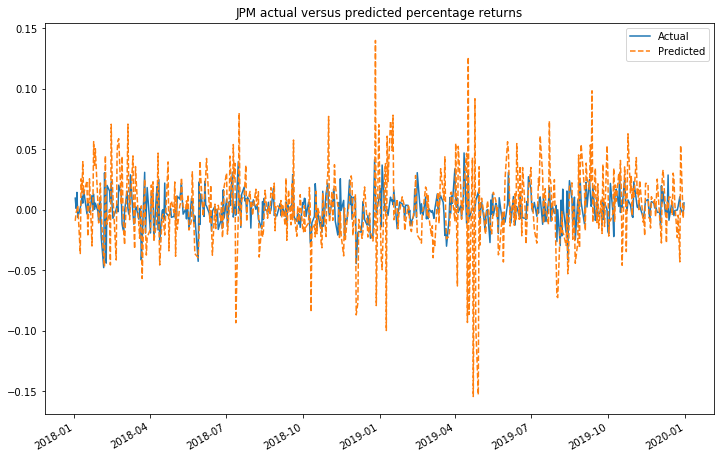

In [39]:
multi_linear_model.df_result.plot(
    title='JPM actual versus predicted percentage returns',
    style=['-', '--'], figsize=(12,8));

In [40]:
print_regression_metrics(multi_linear_model.df_result)

mean_absolute_error: 0.021959271269085735
mean_squared_error: 0.0009592816771169531
explained_variance_score: -4.750088191072776
r2_score: -4.756740348662239


## An ensemble of decision trees

### Bagging regressor

In [44]:
from sklearn.ensemble import BaggingRegressor

class BaggingRegressorModel(LinearRegressionModel):
    def get_model(self):
        return BaggingRegressor(n_estimators=20, random_state=0)  

In [45]:
bagging = BaggingRegressorModel()
bagging.learn(df_lagged, y, start_date='2018', 
              end_date='2019', lookback_period=10)

In [46]:
print_regression_metrics(bagging.df_result)

mean_absolute_error: 0.010913234715624779
mean_squared_error: 0.0002115075219137151
explained_variance_score: -0.26927216495358675
r2_score: -0.26927670411221727


# Predicting trends with classification-based machine learning

## Preparing the target variables

In [47]:
import numpy as np
y_direction = y >= 0

In [48]:
y_direction.head(3)

date
1999-11-02     True
1999-11-03    False
1999-11-04     True
Name: 5. adjusted close, dtype: bool

In [49]:
flags = list(y_direction.unique())
flags.sort()

In [50]:
print(flags)

[False, True]


## Preparing the dataset of multiple assets as input variables

In [51]:
df_input = df_assets_1m.join(df_assets_3m).dropna()

In [52]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3402 entries, 2007-05-25 to 2020-11-25
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPX_1m  3402 non-null   float64
 1   GLD_1m  3402 non-null   float64
 2   UUP_1m  3402 non-null   float64
 3   IEF_1m  3402 non-null   float64
 4   SPX_3m  3402 non-null   float64
 5   GLD_3m  3402 non-null   float64
 6   UUP_3m  3402 non-null   float64
 7   IEF_3m  3402 non-null   float64
dtypes: float64(8)
memory usage: 239.2 KB


## Logistic regression

In [54]:
y_direction

date
1999-11-02     True
1999-11-03    False
1999-11-04     True
1999-11-05     True
1999-11-08    False
              ...  
2020-11-19     True
2020-11-20    False
2020-11-23     True
2020-11-24     True
2020-11-25    False
Name: 5. adjusted close, Length: 5302, dtype: bool

In [55]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(LinearRegressionModel):
    def get_model(self):
        return LogisticRegression(solver='lbfgs')

In [56]:
logistic_reg_model = LogisticRegressionModel()
logistic_reg_model.learn(df_input, y_direction, start_date='2018', 
                         end_date='2019', lookback_period=100)

In [57]:
logistic_reg_model.df_result.head()

,Actual,Predicted
2018-01-02,True,True
2018-01-03,True,True
2018-01-04,True,True
2018-01-05,False,True
2018-01-08,True,True


### Risk metrics for measuring classification-based predictions

### Confusion matrix

In [58]:
from sklearn.metrics import confusion_matrix

df_result = logistic_reg_model.df_result    
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

matrix = confusion_matrix(actual, predicted)

In [59]:
print(matrix)

[[ 96 143]
 [ 98 166]]


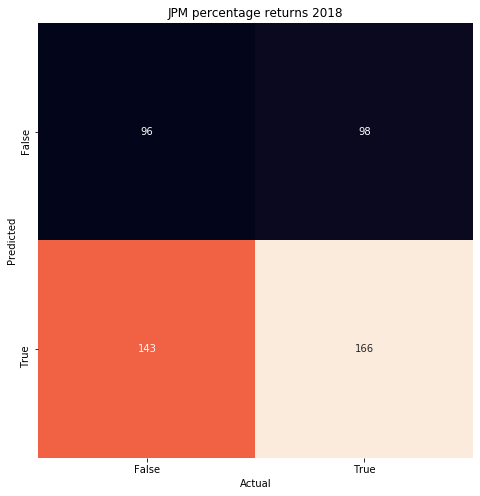

In [60]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('JPM percentage returns 2018');

### Accuracy score

In [61]:
from sklearn.metrics import accuracy_score
print('accuracy_score:', accuracy_score(actual, predicted))

accuracy_score: 0.5208747514910537


### Precision score

In [62]:
from sklearn.metrics import precision_score
print('precision_score:', precision_score(actual, predicted))

precision_score: 0.5372168284789643


### Recall score

In [63]:
from sklearn.metrics import recall_score
print('recall_score:', recall_score(actual, predicted))

recall_score: 0.6287878787878788


### F1 Score

In [64]:
from sklearn.metrics import f1_score
print('f1_score:', f1_score(actual, predicted))

f1_score: 0.5794066317626527


## Support Vector Classifier

In [65]:
from sklearn.svm import SVC

class SVCModel(LogisticRegressionModel):
    def get_model(self):
        return SVC(C=1000, gamma='auto')

In [66]:
svc_model = SVCModel()
svc_model.learn(df_input, y_direction, start_date='2018', 
                end_date='2019', lookback_period=100)

In [67]:
df_result = svc_model.df_result
actual = list(df_result['Actual'])
predicted = list(df_result['Predicted'])

print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted))
print('recall_score:', recall_score(actual, predicted))
print('f1_score:', f1_score(actual, predicted))    

accuracy_score: 0.532803180914513
precision_score: 0.5481727574750831
recall_score: 0.625
f1_score: 0.584070796460177
